In [1]:
import numpy as np
import matplotlib.pyplot as plt

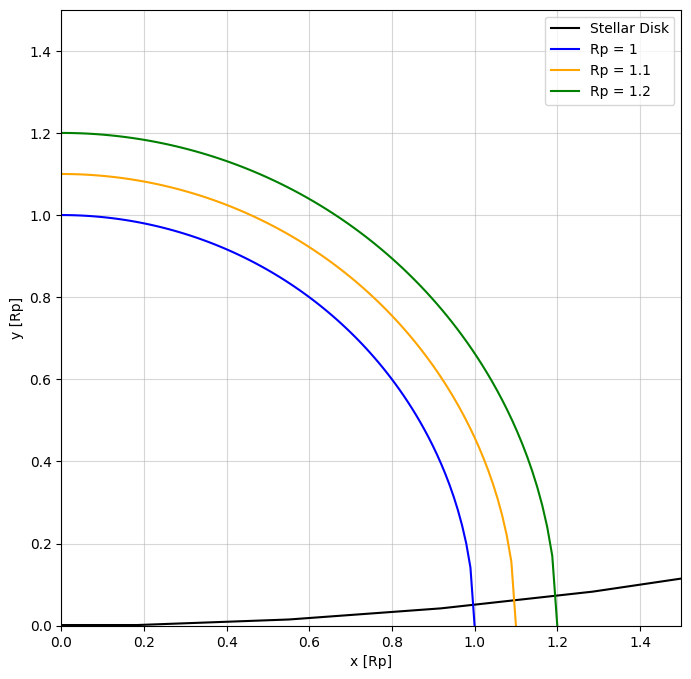

In [2]:
# x,y coordinates centered at the core of the planet
# planet is at "mid-ingress", defined as when y coord of core of planet = y coord of the edge of stellar disk
# assuming planet orbits equatorially, and "moves" along y-axis
# the star is therefore centered at (x=0, y=Rstar)

Rplanet = 1.0
Rstar = 10.*Rplanet

# equation for edge of stellar disk:
xstar = np.linspace(-9, 9, 50)
ystar = Rstar - np.sqrt(Rstar**2 - xstar**2)

# equation for nominal planet
xp0 = np.linspace(0, Rplanet,100)
yp0 = np.sqrt(Rplanet**2 - xp0**2)

# planet + 10%
Rp1 = Rplanet * 1.1
xp1 = np.linspace(0, Rp1, 100)
yp1 = np.sqrt(Rp1**2 - xp1**2)

# planet + 20%
Rp2 = Rplanet * 1.2
xp2 = np.linspace(0, Rp2, 100)
yp2 = np.sqrt(Rp2**2 - xp2**2)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(xstar, ystar, c='black', label='Stellar Disk')
ax.plot(xp0, yp0, c='blue', label='Rp = 1')#, ax.fill_between(xp0, np.zeros(len(yp0)), yp0, fc='lightblue', alpha=1, zorder=3)
ax.plot(xp1, yp1, c='orange', label='Rp = 1.1')#, ax.fill_between(xp1, yp0, yp1, fc='orange', alpha=0.1, zorder=2)
ax.plot(xp2, yp2, c='green', label='Rp = 1.2')#, ax.fill_between(xp2, yp2, yp2, fc='green', alpha=0.1, zorder=1)
ax.set_xlabel('x [Rp]')
ax.set_ylabel('y [Rp]')
ax.set(xlim=(0,1.5), ylim=(0,1.5))
ax.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [3]:
## interpretation:
## y = the extra distance that the planet with larger Rp_morning needs to travel before the entire
##        morning hemisphere is occulting

# the black line is
# y = Rstar - sqrt{Rstar^2 - x^2 }
# 
# Rp = p * Rstar, where p = (Rp/Rs)
# -> Rstar = Rp / p
# -> y = (Rp / p) - sqrt{ (Rp/p)^2 - x^2}
# where y and x in units [Rp]???

Planet properties
bulk scale height H = 1042.34 km


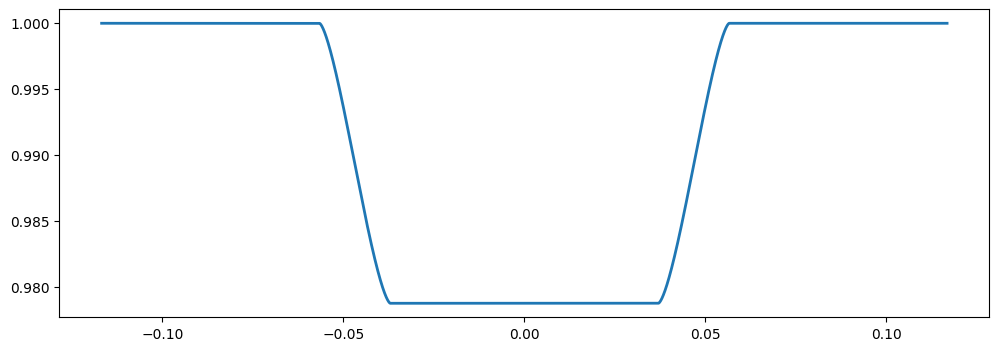

In [45]:
## -- TEST: does this correction correspond to a minimized likelihood? and why?
## as in simulations, generate a "truth" lightcurve but create a slider (or loop) of test, unif.-limb LCs
##    and look at residuals + statistics thereof as function of tc

import batman, catwoman

def calc_H(T, M, R, mm=2.3):
    """ Calculates the approximate scale height of a planet's atmosphere, using the equation
     scale height = kT / mg
    
    Inputs: T = the atmospheric temperature in [K]; M = the planet's mass in [kg]; 
            R = the planet's radius in [m]; mm = mean mass of a molecule in the atmosphere [amu], this is
                   default set to 1 amu = 1 proton mass (for now)
    Outputs: H = the scale height in [m]
    """
    # constants:
    amu = 1.67e-27 # [kg]; atomic mass unit in [kg]
    k = 1.38e-23 # [Joule/K]; Boltzmann constant
    G = 6.674e-11 # [m^3/kg/s^2]; Gravitational constant
    Mjupiter = 1.9e27 # [kg]; mass of Jupiter
    Rjupiter = 69911000.0 # [m]; approx. radius of Jupiter
    # computing the numerator for the scale height equation:
    E_thermal = k*T # [Joule]
    # computing the denominator:
    g = G*M/(R**2) # gravitational acceleration in [m/s^2]
    meanmass = mm*amu
    denominator = meanmass*g # [kg*m/s^2]
    # compute the scale height:
    H = E_thermal / denominator # [meters]
    return H

def get_T1_index(time, y):
    # get the index where T1 occurs
    # defined as where model flux first goes < 1
    pretransit_idxs = np.where((y == 1.0) & (time < np.median(time)))[0] # 'oot' indexes
    T1_idx = pretransit_idxs[-1] 
    return T1_idx
def get_T4_index(time, y):
    # get the index where T4 occurs
    # defined as where model flux last goes = 1
    posttransit_idxs = np.where((y == 1.0) & (time > np.median(time)))[0] # 'oot' indexes
    T4_idx = posttransit_idxs[0] 
    return T4_idx

def calc_impact_param(a_over_Rstar, inc):
    # assumes a circular orbit
    # Inputs:
    # a_over_Rstar = orbital semi-major-axis in units of stellar radii
    # inc = orbital inclination in [degrees]
    b = a_over_Rstar*np.cos(np.deg2rad(inc))
    return b

## ANALYTIC FUNCTIONS
def predict_dT1(period, semi_maj_axis, impact_param, Rstar, Rmorning, Runiform):
    # Inputs:
    # period = orbital period in any time units, will just become the output unit
    # semi_maj_axis = orbital semi-major-axis in same units as the input radii parameters, as the length units cancel
    # impact_param = orbital impact parameter (w.r.t. stellar equator), unitless
    # Rstar = radius of the star
    # Rmorning = radius of the planet's morning-limb
    # Runiform = radius of the equivalent-depth uniform-limb planet
    prefactor = period / (2.*np.pi*semi_maj_axis)
    term1 = np.sqrt( (Rstar + Rmorning)**2 - (impact_param * Rstar)**2 )
    term2 = np.sqrt( (Rstar + Runiform)**2 - (impact_param * Rstar)**2 )
    calc = prefactor*(term1 - term2)
    return calc

def predict_dT4(period, semi_maj_axis, impact_param, Rstar, Revening, Runiform):
    # same calculation as deltaT1, but replace {Rmorning, Runiform} in dT1 calc with {Runiform, Revening} here
    calc = predict_dT1(period, semi_maj_axis, impact_param, Rstar, Runiform, Revening)
    return calc

AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7
Mjup_to_kg = 1.899e27

# create a planet
tc = 0.         # [day]
per = 4.0552941 # [day]
a = 11.55       # [stellar radii]
inc = 87.32      # [degrees]
phi = 90.
ecc = 0.
w = 90.
r = 0.1457 # [stellar radii]
Rs = 0.92868 # [Rsun]
Mp_jup = 0.281 # [jupiter masses]
Teq = 1166.0 # [K]
T14 = 2.8032 # duration [hours]

# calculate things in physical units
a_meter = a * Rs * Rsun_to_meter
per_seconds = per*day_to_second
Rs_meter = Rs * Rsun_to_meter
Rp_meter = r * Rs_meter
Mp_kg = Mp_jup * Mjup_to_kg

# calculate other things
v_orb = (2.*np.pi*a_meter) / (per_seconds) # [m/s]
H = calc_H(Teq, Mp_kg, Rp_meter, mm=2.3) # [m]
impactparam = calc_impact_param(a, inc) # [unitless]

# simulated obs. info from or based on pandexo
t_int = 0.5 #79.5 # [s] per integration
obs_window_size = (1.0*T14) / 24. # half-duration of whole observation in [day]
t = np.arange(-obs_window_size, obs_window_size, (t_int / 60./60./24.))

print('Planet properties')
print('bulk scale height H = %.2f km'%(H/1000.))

## -- initialize transit model environments
## -- Catwoman:
aparams  = catwoman.TransitParams()
aparams.t0 = tc                          #time of inferior conjuction (in days)
aparams.per = per                         #orbital period (in days)
aparams.rp = r                        #top semi-circle radius (in units of stellar radii)
aparams.rp2 = r                        #bottom semi-circle radius (in units of stellar radii)
aparams.a = a                         #semi-major axis (in units of stellar radii)
aparams.inc = inc                        #orbital inclination (in degrees)
aparams.ecc = ecc                        #eccentricity
aparams.w = w                         #longitude of periastron (in degrees)
aparams.limb_dark = "uniform"          #limbs darkening model
aparams.phi = phi                         #angle of rotation of top semi-circle (in degrees)
asymmodel = catwoman.TransitModel(aparams,t)         #initalises model
#asymLC = asymmodel.light_curve(params)                #calculates light curve

## -- Batman:
uparams  = batman.TransitParams()
uparams.t0 = tc                          #time of inferior conjuction (in days)
uparams.per = per                         #orbital period (in days)
uparams.rp = r                        #top semi-circle radius (in units of stellar radii)
uparams.a = a                         #semi-major axis (in units of stellar radii)
uparams.inc = inc                        #orbital inclination (in degrees)
uparams.ecc = ecc                        #eccentricity
uparams.w = w                         #longitude of periastron (in degrees)
uparams.u = []                   #limb darkening coefficients [u1, u2]
uparams.limb_dark = "uniform"          #limbs darkening model
unifmodel = batman.TransitModel(uparams,t)         #initalises model
#unifLC = unifmodel.light_curve(bparams)                #calculates light curve

## note:
## we assume uniform LD for simplicity. it speeds up the initialization, the fitting, and allows easier estimations
##   of light curve contact points.

## -- Define Bayesian inference functions for use in MCMC
def logLikelihood(ydata, yerr, modely):
    """ Computes the Bayesian likelihood of a model, given the data (or is it the other way around?)
    Inputs: ydata = your data, yerr= uncertainties on your data, modely = same size array of the model's values
    outputs: ln( the likelihood )
    """
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    return lnL

def lnPosterior(tc_fitting, t, y, yerr, adj_rprs, inittransitenv):
    ## computes the log Posterior of model, given data
    ## we are fitting data (generated from an asymmetric-limb model) using
    ##   a uniform-limb transit model, and fitting for the tc
    ## Major input is the tc parameter, and the uniform-limb rprs. Other transit params. are fixed to their true values
    #
    # Take step's tc and gen. a uniform-limb model, using fixed true transit params.
    fitparams  = batman.TransitParams()
    fitparams.t0 = tc_fitting                          #time of inferior conjuction (in days)
    fitparams.per = per                         #orbital period (in days)
    fitparams.rp = adj_rprs                        #top semi-circle radius (in units of stellar radii)
    fitparams.a = a                         #semi-major axis (in units of stellar radii)
    fitparams.inc = inc                        #orbital inclination (in degrees)
    fitparams.ecc = ecc                        #eccentricity
    fitparams.w = w                         #longitude of periastron (in degrees)
    fitparams.u = []                   #limb darkening coefficients [u1, u2]
    fitparams.limb_dark = "uniform"          #limbs darkening mode
    fit_LC = inittransitenv.light_curve(fitparams)                #calculates light curve
    # calculate likelihood of this model, given input data
    lnL = logLikelihood(y, yerr, fit_LC)
    # we ignore priors, so this likelihood is it
    return lnL

## -- plot model LC to make sure things worked
fig,ax = plt.subplots(figsize=(12,4))
lc_init = asymmodel.light_curve(aparams)
#lc_init = unifmodel.light_curve(uparams)
ax.plot(t, lc_init, lw=2)
plt.show()

In [46]:
## -- Set up the "truth"
# define what N to use
Nval = 2.5
# set the evening limb to some pre-defined value, that doesn't change
Rp_evening_meter = Rp_meter # true evening-limb radius in [m]
rprs_evening = Rp_evening_meter / Rs_meter
# define limb extension
dR_meter = Nval * H # difference btwn. evening- and morning-limb radii in [m]
dr = dR_meter / Rs_meter # difference btwn. evening- and morning-limb Rp/Rs
# extend morning by this amount
Rp_morning_meter = Rp_evening_meter + dR_meter # true morning-limb radius in [m]
rprs_morning = Rp_morning_meter / Rs_meter
# and calculate Rp based on analagous homogeneous transit depth
#Rp_uniform_m = np.sqrt((Rp_evening_m**2) + (Rp_evening_m * dR_m) + (dR_m**2)) # in [m]
Rp_uniform_meter = np.sqrt(0.5*(Rp_evening_meter**2 + Rp_morning_meter**2))
rprs_uniform = Rp_uniform_meter / Rs_meter

print('N = %.2f, H = %.1f km'%(Nval, H/1000.))
print('dR = %.1f m (%.1f scale heights, %.2f percent of Rp)'%(dR_meter, Nval, (100.*dR_meter/Rp_evening_meter)))
print('Evening limb radius = %.1f m'%(Rp_evening_meter))
print('Morning limb radius = %.1f m'%(Rp_morning_meter))
print('Analogous uniform limb radius = %.1f m'%(Rp_uniform_meter))
print('     = %.4f x evening limb '%(Rp_uniform_meter / Rp_evening_meter))
print('     = %.4f x morning limb '%(Rp_uniform_meter / Rp_morning_meter))

print('dr = %.4f '%(dr))
print('Evening limb Rp/Rs = %.4f'%(rprs_evening))
print('Morning limb Rp/Rs = %.4f'%(rprs_morning))
print('Analogous uniform limb Rp/Rs = %.4f'%(rprs_uniform))
print('     = %.4f x evening limb '%(rprs_uniform / rprs_evening))
print('     = %.4f x morning limb '%(rprs_uniform / rprs_morning))

# calculate predicted timing bias

# update transit model parameters to generate asymmetric-limb LC
#    doing it from scratch to prevent aliasing errors
# For the "true" asymmetric planet
trueparams_a  = catwoman.TransitParams()
trueparams_a.t0 = tc            #time of inferior conjuction (in days)
trueparams_a.per = per            #orbital period (in days)
trueparams_a.rp = rprs_evening    #top semi-circle radius (in units of stellar radii)
trueparams_a.rp2 = rprs_morning   #bottom semi-circle radius (in units of stellar radii)
trueparams_a.phi = phi          #angle of rotation of top semi-circle (in degrees)
trueparams_a.a = a            #semi-major axis (in units of stellar radii)
trueparams_a.inc = inc          # orbital inclination (in degrees)
trueparams_a.ecc = ecc          #eccentricity
trueparams_a.w = w              #longitude of periastron (in degrees)
trueparams_a.limb_dark = "uniform"  #limbs darkening model
# generate the "true" light curve to use for data initialization
lc_truth = asymmodel.light_curve(trueparams_a)


N = 2.50, H = 1042.3 km
dR = 2605860.4 m (2.5 scale heights, 2.77 percent of Rp)
Evening limb radius = 94134245.9 m
Morning limb radius = 96740106.3 m
Analogous uniform limb radius = 95446069.6 m
     = 1.0139 x evening limb 
     = 0.9866 x morning limb 
dr = 0.0040 
Evening limb Rp/Rs = 0.1457
Morning limb Rp/Rs = 0.1497
Analogous uniform limb Rp/Rs = 0.1477
     = 1.0139 x evening limb 
     = 0.9866 x morning limb 


In [51]:
predicted_dT1_sec = predict_dT1(per, a_meter, impactparam, Rs_meter, Rp_morning_meter, Rp_uniform_meter)*day_to_second
predicted_dT4_sec = predict_dT4(per, a_meter, impactparam, Rs_meter, Rp_evening_meter, Rp_uniform_meter)*day_to_second
dt_predicted = -0.5*(predicted_dT1_sec + predicted_dT4_sec) # [s]

dt_fit = -12.38

In [52]:
utestparams  = batman.TransitParams()
utestparams.t0 = 0. + (dt_predicted/24./60./60.)                        #time of inferior conjuction (in days)
utestparams.per = per                         #orbital period (in days)
utestparams.rp = rprs_uniform                        #top semi-circle radius (in units of stellar radii)
utestparams.a = a                         #semi-major axis (in units of stellar radii)
utestparams.inc = inc                        #orbital inclination (in degrees)
utestparams.ecc = ecc                        #eccentricity
utestparams.w = w                         #longitude of periastron (in degrees)
utestparams.u = []                   #limb darkening coefficients [u1, u2]
utestparams.limb_dark = "uniform"          #limbs darkening mode
lc_test = unifmodel.light_curve(utestparams)                #calculates light curve

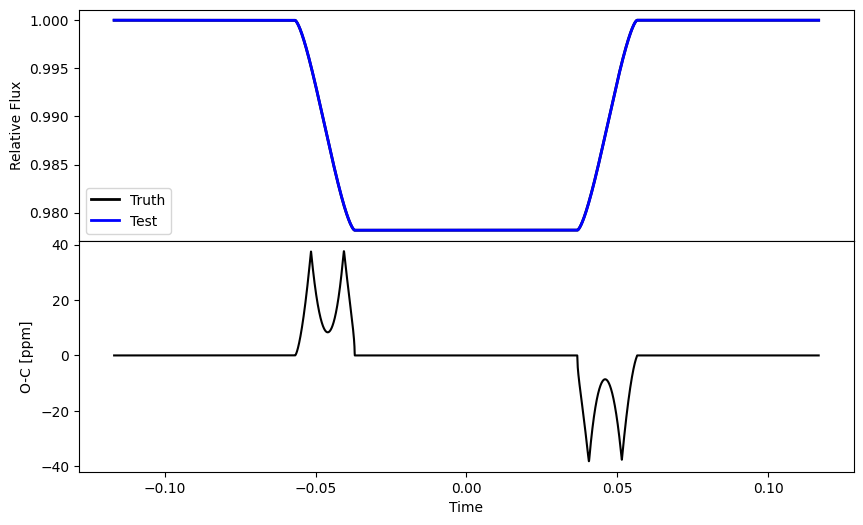

In [53]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2, gridspec_kw={'height_ratios':[1,1]})
plt.subplots_adjust(hspace=0.)
# top - LCs
ax[0].plot(t, lc_truth, c='black', lw=2, label='Truth')
ax[0].plot(t, lc_test, c='blue', lw=2, label='Test')
ax[0].set(ylabel='Relative Flux')
ax[0].legend(loc='best')
# bottom - residuals
these_residuals = (lc_test - lc_truth)
ax[1].plot(t, these_residuals*1.e6, c='black')
ax[1].set(ylabel='O-C [ppm]', xlabel='Time')
plt.show()

In [54]:
# things to calculate --
# 0. array of residuals
# 1. mean residual
# 2. root mean square residual
# 3. chi^2
# 4. ln(likelihood) [CANT DO / IS MEANINGLESS WITHOUT DATA UNCERTAINTY]
# as func. of dt

dt_testvals = np.linspace(dt_predicted-10., 0., 40)
residuals_all = np.zeros((len(dt_testvals), len(t)))
mean_residuals = np.zeros(len(dt_testvals))
RMSs = np.zeros(len(dt_testvals))
chi2s = np.zeros(len(dt_testvals))
lnLs = np.zeros(len(dt_testvals))

for i, dt_val in enumerate(dt_testvals):
    # clean up batman params object
    try:
        # if it exists already, clear it
        del utestparams
    except:
        ... # do nothing
        
    # first, generate the uniform-limb light curve
    utestparams  = batman.TransitParams()
    utestparams.t0 = 0. + (dt_val/24./60./60.)                        #time of inferior conjuction (in days)
    utestparams.per = per                         #orbital period (in days)
    utestparams.rp = rprs_uniform                        #top semi-circle radius (in units of stellar radii)
    utestparams.a = a                         #semi-major axis (in units of stellar radii)
    utestparams.inc = inc                        #orbital inclination (in degrees)
    utestparams.ecc = ecc                        #eccentricity
    utestparams.w = w                         #longitude of periastron (in degrees)
    utestparams.u = []                   #limb darkening coefficients [u1, u2]
    utestparams.limb_dark = "uniform"          #limbs darkening mode
    lc_test = unifmodel.light_curve(utestparams)                #calculates light curve
    
    # calculate residuals w.r.t. truth in units [ppm]
    these_residuals = (lc_test - lc_truth)*1.e6
    # save
    residuals_all[i] = these_residuals
    
    # calc mean abs. val residual
    mean_residuals[i] = np.mean(abs(these_residuals))
    # calc RMS of residuals
    RMSs[i] = np.sqrt(np.sum((these_residuals**2))/len(these_residuals))
    # calc chi^2
    chi2arr = ((lc_test - lc_truth)**2)/lc_truth
    chi2s[i] = np.sum(chi2arr)
    
    


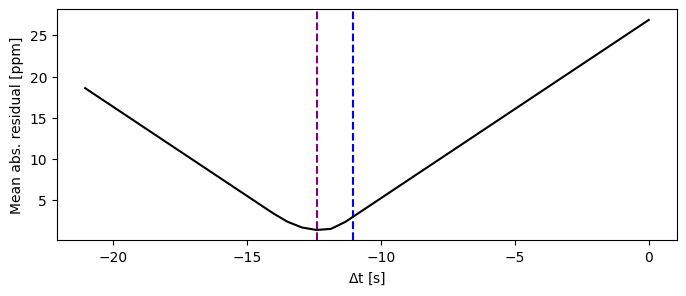

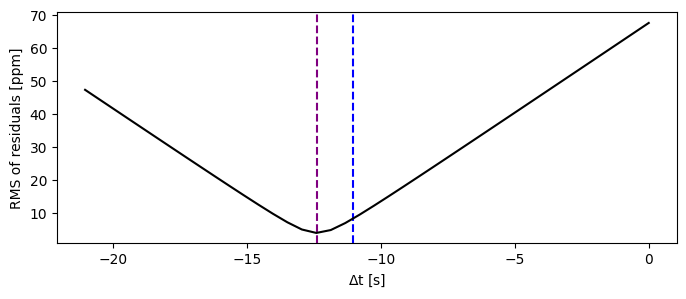

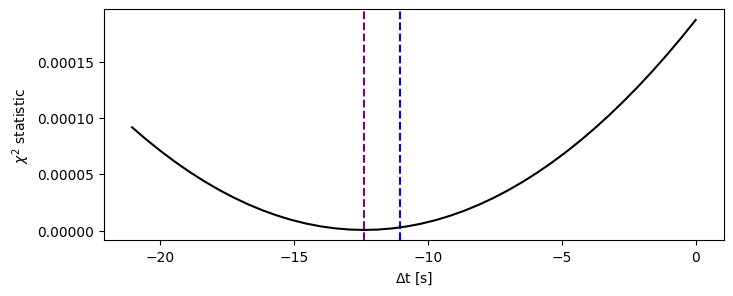

In [55]:
## PLOT results

# mean
fig, ax = plt.subplots(figsize=(8,3))
ax.axvline(dt_predicted, c='blue', ls='--', label='Predicted')
ax.axvline(dt_fit, c='purple', ls='--', label='Est. Fit')
ax.plot(dt_testvals, mean_residuals, c='black')
ax.set(ylabel='Mean abs. residual [ppm]', xlabel='$\Delta$t [s]')
plt.show()

# RMS residuals
fig, ax = plt.subplots(figsize=(8,3))
ax.axvline(dt_predicted, c='blue', ls='--', label='Predicted')
ax.axvline(dt_fit, c='purple', ls='--', label='Est. Fit')
ax.plot(dt_testvals, RMSs, c='black')
ax.set(ylabel='RMS of residuals [ppm]', xlabel='$\Delta$t [s]')
plt.show()

# chi-squared
fig, ax = plt.subplots(figsize=(8,3))
ax.axvline(dt_predicted, c='blue', ls='--', label='Predicted')
ax.axvline(dt_fit, c='purple', ls='--', label='Est. Fit')
ax.plot(dt_testvals, chi2s, c='black')
ax.set(ylabel=r'$\chi^2$ statistic', xlabel='$\Delta$t [s]')
plt.show()

In [56]:
min_chi_idx = np.argmin(chi2s)
pred_idx = np.searchsorted(dt_testvals, dt_predicted)
estfit_idx = np.searchsorted(dt_testvals, 1.1*dt_predicted)

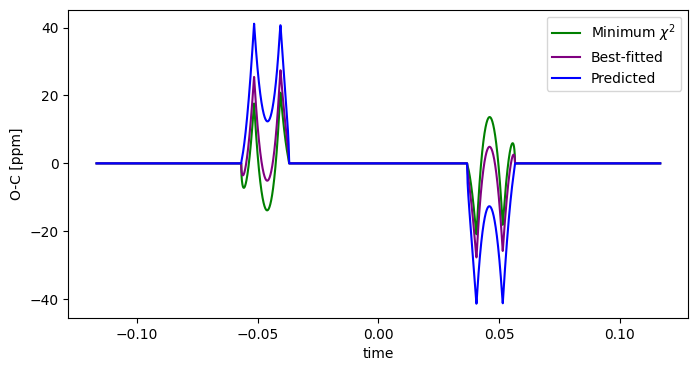

In [58]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(t, residuals_all[min_chi_idx], c='green', label=r'Minimum $\chi^2$')
ax.plot(t, residuals_all[estfit_idx], c='purple', label='Best-fitted')
ax.plot(t, residuals_all[pred_idx], c='blue', label='Predicted')
ax.set(xlabel='time', ylabel='O-C [ppm]')
ax.legend(loc='best')
plt.show()